<a href="https://colab.research.google.com/github/iaintheardofu/AutoAgent/blob/main/class-2/class-2-CL-Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The SimCLR approach aims to learn meaningful representations of images in a self-supervised manner. It does this by maximizing the cosine similarity between representations of augmented views of the same image (positive pairs) and minimizing the cosine similarity between representations of different images (negative pairs). The contrastive loss encourages the encoder to learn representations that are invariant to the applied data augmentations.

The visualization using t-SNE allows us to assess the quality of the learned representations by observing how well the different classes are separated in the low-dimensional space.

This code demonstrates the implementation of a self-supervised learning approach called SimCLR (Simple Framework for Contrastive Learning of Visual Representations) using the CIFAR-10 dataset. Let's go through the code section by section:

1. Importing Libraries:
   - The necessary libraries, including TensorFlow, Keras, Matplotlib, and scikit-learn, are imported.

2. Loading and Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The pixel values of the training and testing data are normalized to the range [0, 1].
   - The training data is converted into a TensorFlow Dataset using `tf.data.Dataset.from_tensor_slices()` and batched.

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random cropping, flipping, rescaling, and zooming to the input images.

4. Defining the Encoder Network:
   - The `create_encoder` function defines the base encoder network using convolutional layers, max pooling, and a global max pooling layer.
   - The encoder network takes an input image and outputs a 128-dimensional feature representation.

5. Defining the Projection Head:
   - The `create_projection_head` function defines the projection head network using dense layers.
   - The projection head takes the 128-dimensional feature representation from the encoder and projects it to a 128-dimensional space.

6. Training Loop:
   - The training loop runs for a specified number of epochs.
   - For each batch of training data:
     - The encoder and projection head are applied to the batch of images.
     - The resulting projected representations are L2-normalized.
     - The cosine similarity matrix is computed between the normalized representations.
     - The contrastive loss is calculated using the cosine similarity matrix and temperature scaling.
     - The gradients of the loss with respect to the weights of the encoder and projection head are computed.
     - The optimizer is used to update the weights of the encoder and projection head.

7. Extracting Representations:
   - After training, the trained encoder is used to extract representations (embeddings) for the test images.

8. t-SNE Visualization:
   - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
   - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

Epoch 1/10
Step 0: Loss = 6.0816
Step 100: Loss = 0.4104

Epoch 2/10
Step 0: Loss = 0.2934
Step 100: Loss = 0.2738

Epoch 3/10
Step 0: Loss = 0.2035
Step 100: Loss = 0.1734

Epoch 4/10
Step 0: Loss = 0.1464
Step 100: Loss = 0.1557

Epoch 5/10
Step 0: Loss = 0.1411
Step 100: Loss = 0.1496

Epoch 6/10
Step 0: Loss = 0.1631
Step 100: Loss = 0.1335

Epoch 7/10
Step 0: Loss = 0.1278
Step 100: Loss = 0.1087

Epoch 8/10
Step 0: Loss = 0.1218
Step 100: Loss = 0.1376

Epoch 9/10
Step 0: Loss = 0.1074
Step 100: Loss = 0.1126

Epoch 10/10
Step 0: Loss = 0.1181
Step 100: Loss = 0.1158
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


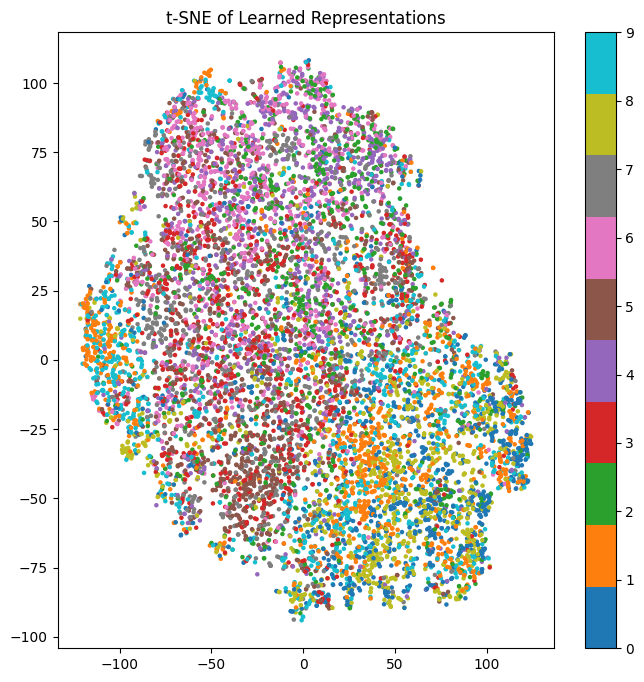

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

batch_size = 256

# Convert the training data into a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)

# Data augmentation
data_augmentation = keras.Sequential([
	layers.RandomCrop(32, 32),
	layers.RandomFlip('horizontal'),
	layers.RandomZoom(0.2),
])

# Encoder
def create_encoder():
	inputs = layers.Input(shape=(32, 32, 3))
	x = layers.Conv2D(32, 3, activation='relu')(inputs)
	x = layers.MaxPooling2D()(x)
	x = layers.Conv2D(64, 3, activation='relu')(x)
	x = layers.MaxPooling2D()(x)
	x = layers.Conv2D(128, 3, activation='relu')(x)
	x = layers.GlobalAveragePooling2D()(x)
	x = layers.Dense(128)(x)
	return keras.Model(inputs, x)

# Projection head
def create_projection_head():
	inputs = keras.Input(shape=(128,))
	x = layers.Dense(256, activation='relu')(inputs)
	outputs = layers.Dense(128)(x)
	return keras.Model(inputs, outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
temperature = 0.1
epochs = 10

# Contrastive loss (simple cosine similarity with identity labels)
def contrastive_loss(projections_1, projections_2):
	proj_1 = tf.math.l2_normalize(projections_1, axis=1)
	proj_2 = tf.math.l2_normalize(projections_2, axis=1)

	# Combine both views
	features = tf.concat([proj_1, proj_2], axis=0)
	similarity_matrix = tf.matmul(features, features, transpose_b=True)

	# Mask out self-similarity
	batch_size = tf.shape(projections_1)[0]
	mask = tf.eye(2 * batch_size)
	similarity_matrix = similarity_matrix * (1 - mask)

	# Labels are just indexes of positives across the concatenated batch
	labels = tf.range(batch_size)
	labels = tf.concat([labels + batch_size, labels], axis=0)

	logits = similarity_matrix / temperature
	loss = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
	return tf.reduce_mean(loss)

# Training loop
for epoch in range(epochs):
	print(f'\nEpoch {epoch + 1}/{epochs}')
	for step, x_batch in enumerate(train_dataset):
		with tf.GradientTape() as tape:
			augmented_1 = data_augmentation(x_batch)
			augmented_2 = data_augmentation(x_batch)

			features_1 = encoder(augmented_1, training=True)
			features_2 = encoder(augmented_2, training=True)

			proj_1 = projection_head(features_1, training=True)
			proj_2 = projection_head(features_2, training=True)

			loss = contrastive_loss(proj_1, proj_2)

		variables = encoder.trainable_variables + projection_head.trainable_variables
		grads = tape.gradient(loss, variables)
		optimizer.apply_gradients(zip(grads, variables))

		if step % 100 == 0:
			print(f'Step {step}: Loss = {loss.numpy():.4f}')

# Inference on test data
features_test = encoder.predict(x_test, batch_size=batch_size)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(features_test)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='tab10', s=5)
plt.title('t-SNE of Learned Representations')
plt.colorbar()
plt.show()